# Axis Tuning

In [1]:
import math
import numpy as np
import socket
import time

# Import matplotlib and put it in interactive mode.
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

from ophyd.scaler import ScalerCH
from ophyd import EpicsMotor, EpicsSignal
from bluesky import RunEngine
from bluesky.callbacks.best_effort import BestEffortCallback
import bluesky.plans as bp 
# Make plots update live while scans run.
from bluesky.utils import install_nb_kicker
install_nb_kicker()

from APS_BlueSky_tools.synApps_ophyd import userCalcsDevice, swait_setup_lorentzian


hostname = socket.gethostname()

HOST_PV_PREFIX_DICT = {
    'otz.aps.anl.gov': "gov:",
    'mint-vm': "prj:",
    'poof': "prj:",
    'enoki': "prj:",
    }
IOC_PREFIX = HOST_PV_PREFIX_DICT.get(hostname, "xxx:")


RE = RunEngine({})
RE.subscribe(BestEffortCallback())


def setRandomPeak(calc, motor):
    swait_setup_lorentzian(
        calc, 
        motor, 
        center = -1.5 + 0.5*np.random.uniform(), 
        noise  = 0.2  + 0.2*np.random.uniform(), 
        width  = 0.001 + 0.05*np.random.uniform(), 
        scale  = 1e5,
        )

In [2]:
from APS_BlueSky_tools.devices import AxisTunerMixin
from APS_BlueSky_tools.plans import TuneAxis


class TunableEpicsMotor(EpicsMotor, AxisTunerMixin):
    pass


m1 = TunableEpicsMotor(IOC_PREFIX+"m1", name="m1")
calcs = userCalcsDevice(IOC_PREFIX, name="calcs")

In [3]:
# change soft motor resolution from 200 steps/rev to 8000 (steps of 0.00025)
_srev = EpicsSignal(m1.prefix+".SREV", name="_srev")
_srev.put(8000)

In [4]:
noisy_calc = calcs.calc1
setRandomPeak(noisy_calc, m1)

print("programmed peak signal: {}".format(calcs.calc1.channels.D.value.value))
print("programmed center: {}".format(calcs.calc1.channels.B.value.value))
sigma = calcs.calc1.channels.C.value.value
fwhm = 2*math.sqrt(2* sigma**2 * math.log(2))
print("programmed sigma: {}".format(sigma))
print("programmed FWHM: {}".format(fwhm))
print("programmed noise: {}".format(calcs.calc1.channels.E.value.value))

programmed peak signal: 100000.0
programmed center: -1.4866858384541972
programmed sigma: 0.04303557291504972
programmed FWHM: 0.10134102974975008
programmed noise: 0.21422259898507692


In [5]:
noisy = EpicsSignal(noisy_calc.prefix, name="noisy")

In [6]:
m1.tuner = TuneAxis([noisy], m1, signal_name=noisy.name)
# m1.tuner = MyTuneAxis([det], m1, signal_name="det")
m1.tuner.width = 5
m1.tuner.num = 21

m1.move(0)

MoveStatus(done=True, pos=m1, elapsed=1.4, success=True, settle_time=0.0)

m1 position before tuning: 0.0
Transient Scan ID: 1     Time: 2018/09/20 12:44:14
Persistent Unique Scan ID: '1e1a8912-2274-43e3-8402-af51d13b2182'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+


<IPython.core.display.Javascript object>


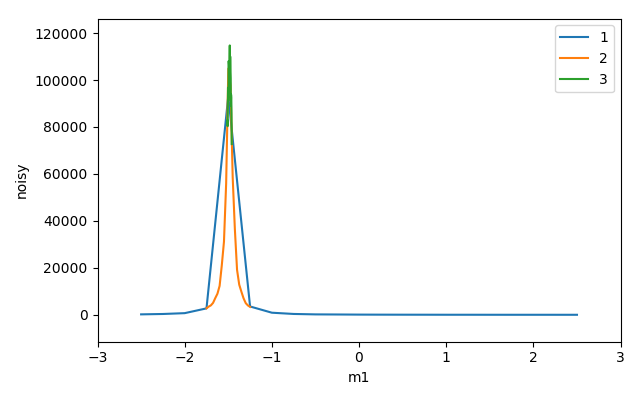

|         1 | 12:44:17.0 |   -2.50000 |  194.43851 |
|         2 | 12:44:17.4 |   -2.25000 |  354.32679 |
|         3 | 12:44:17.9 |   -2.00000 |  708.08894 |
|         4 | 12:44:18.4 |   -1.75000 | 2746.15459 |
|         5 | 12:44:18.9 |   -1.50000 | 93174.64515 |
|         6 | 12:44:19.4 |   -1.25000 | 3555.33747 |
|         7 | 12:44:19.9 |   -1.00000 |  898.00443 |
|         8 | 12:44:20.4 |   -0.75000 |  366.15033 |
|         9 | 12:44:20.9 |   -0.50000 |  184.19517 |
|        10 | 12:44:21.4 |   -0.25000 |  139.84171 |
|        11 | 12:44:21.9 |    0.00000 |   89.80359 |
|        12 | 12:44:22.4 |    0.25000 |   66.37262 |
|        13 | 12:44:22.9 |    0.50000 |   50.87519 |
|        14 | 12:44:23.4 |    0.75000 |   42.81153 |
|        15 | 12:44:23.9 |    1.00000 |   29.87013 |
|        16 | 12:44:24.4 |    1.25000 |   28.69736 |
|        17 | 12:44:24.9 |    1.50000 |   21.59114 |
|        18 | 12:44:25.4 |    1.75000 |   17.00983 |
|        19 | 12:44:25.9 |    2.00000 |   17.

('1e1a8912-2274-43e3-8402-af51d13b2182',)

In [7]:
RE(m1.tune())

In [8]:
m1.tuner.width /= 10
RE(m1.tune())

m1 position before tuning: -1.4995
Transient Scan ID: 2     Time: 2018/09/20 12:44:31
Persistent Unique Scan ID: 'b15a5093-1e72-4f13-9c09-c6e4a93ee293'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+
|         1 | 12:44:31.9 |   -1.74950 | 2782.91323 |
|         2 | 12:44:32.1 |   -1.72450 | 3500.12051 |
|         3 | 12:44:32.3 |   -1.69950 | 4027.49861 |
|         4 | 12:44:32.5 |   -1.67450 | 5088.67447 |
|         5 | 12:44:32.7 |   -1.64950 | 7106.14352 |
|         6 | 12:44:32.9 |   -1.62450 | 8986.53473 |
|         7 | 12:44:33.1 |   -1.59950 | 12325.07007 |
|         8 | 12:44:33.3 |   -1.57450 | 21069.04987 |
|         9 | 12:44:33.5 |   -1.54950 | 31174.84924 |
|        10 | 12:44:33.7 |   -1.52450 | 55970.91990 |
|        11 | 12:44:33.9 |   -1.49950 | 104903.65626 |
|        12 | 12:44:34.1 |   -1.47450 | 97626.22636 |
|        13 | 12:44:34.3

('b15a5093-1e72-4f13-9c09-c6e4a93ee293',)

In [9]:
m1.tuner.width /= 10
RE(m1.tune())

m1 position before tuning: -1.4855
Transient Scan ID: 3     Time: 2018/09/20 12:44:36
Persistent Unique Scan ID: '34f63c03-217f-4ecf-b1d6-fc584214e82c'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+
|         1 | 12:44:36.7 |   -1.51050 | 82700.99999 |
|         2 | 12:44:36.9 |   -1.50800 | 80340.84894 |
|         3 | 12:44:37.0 |   -1.50550 | 87083.68535 |
|         4 | 12:44:37.1 |   -1.50300 | 96699.89222 |
|         5 | 12:44:37.2 |   -1.50050 | 91142.71156 |
|         6 | 12:44:37.3 |   -1.49800 | 92683.24585 |
|         7 | 12:44:37.4 |   -1.49550 | 108093.54338 |
|         8 | 12:44:37.5 |   -1.49300 | 106375.10738 |
|         9 | 12:44:37.6 |   -1.49050 | 95535.20627 |
|        10 | 12:44:37.7 |   -1.48800 | 99021.80962 |
|        11 | 12:44:37.8 |   -1.48550 | 107785.24698 |
|        12 | 12:44:38.0 |   -1.48300 | 114741.48958 |
|        13 | 1

('34f63c03-217f-4ecf-b1d6-fc584214e82c',)